In [1]:
import logging

import matplotlib.pyplot as plt
import pandas as pd
from itertools import combinations
from ev_station_solver.constants import CONSTANTS
from ev_station_solver.loading import load_locations
import numpy as np
from tqdm import tqdm
from ev_station_solver.solving.solver import Solver
from ev_station_solver.helper_functions import get_distance_matrix

In [29]:
# use given starting solutions
locations = load_locations("medium").sample(1000).values
n_clusters = int(len(locations) * CONSTANTS["mu_charging"] / (2 * CONSTANTS["station_ub"]))
service_level = 0.95

n_clusters = 3 if n_clusters < 3 else n_clusters

In [30]:
s = Solver(vehicle_locations=locations, loglevel=logging.INFO, service_level=service_level)

# compute number of initial locations
s.add_initial_locations(n_clusters, mode="k-means", seed=0)
s.add_samples(num=2)

2025-01-13 12:34:35,661 - ev_station_solver.solving.solver - INFO - add_initial_locations: Added 26 k-means locations. Total number of locations: 26.
2025-01-13 12:34:35,665 - ev_station_solver.solving.solver - INFO - add_samples: Added 2 samples.


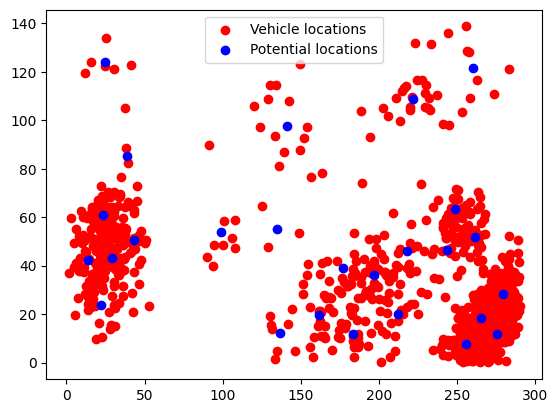

In [31]:
plt.scatter(s.vehicle_locations[:, 0], s.vehicle_locations[:, 1], c="red", label="Vehicle locations")
plt.scatter(s.coordinates_potential_cl[:, 0], s.coordinates_potential_cl[:, 1], c="blue", label="Potential locations")
plt.legend()
plt.show()

In [32]:
# create dataframe with all unique locations and the minimum range
locations = np.empty((0, 2))
ranges = np.empty(0)

for sample in s.S:
    # concatenate locations
    locations = np.concatenate((locations, sample.vehicle_locations), axis=0)
    # concatenate ranges
    ranges = np.concatenate((ranges, sample.ranges), axis=0)

In [33]:
# sort locations by range
sorted_indices = np.argsort(ranges)
locations = locations[sorted_indices]
ranges = ranges[sorted_indices]

In [34]:
# drop duplicates
unique_locations, unique_index = np.unique(locations, axis=0, return_index=True)
# update ranges
unique_ranges = ranges[unique_index]

In [35]:
# get distance matrix
distance_matrix = get_distance_matrix(unique_locations, symmetric=True)
total_ranges = unique_ranges[:, np.newaxis] + unique_ranges[np.newaxis, :]
reachibility_matrix = distance_matrix <= total_ranges
reachibility_matrix

array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True]], shape=(668, 668))

In [36]:
from docplex.mp.model import Model

In [37]:
m = Model("ev_station")

In [38]:
# valid_intersections = set()

# for i in tqdm(range(len(unique_locations))):
#     # get all true indicies of the reachability matrix
#     reachability_indices = np.where(reachibility_matrix[i])[0]
#     # remove i
#     reachibility_indices = np.delete(reachability_indices, reachability_indices== i)
#     # convert to list
#     reachability_indices = reachability_indices.tolist()

#     # compute all possible combinations for all rs
#     for k in range(len(reachability_indices)):
#         for combination in combinations(reachability_indices, k):
#             valid_intersections.add(combination)

In [39]:
import rustworkx as rw

In [40]:
G = rw.PyGraph().from_adjacency_matrix(reachibility_matrix.astype(float))  # create graph from adjacency matrix

In [41]:
results = []
for i, k in enumerate(tqdm(range(len(unique_locations))[::-1])):
    results.append(rw.connected_subgraphs(G, k=k))

    if i == 1:
        break

: 

: 

In [16]:
k

26

In [15]:
results

[[[5,
   14,
   15,
   2,
   13,
   6,
   22,
   27,
   20,
   7,
   25,
   17,
   11,
   3,
   28,
   12,
   1,
   18,
   4,
   8,
   0,
   21,
   23,
   10,
   16,
   26,
   19,
   24],
  [5,
   14,
   15,
   2,
   13,
   6,
   22,
   27,
   20,
   25,
   17,
   11,
   3,
   28,
   12,
   1,
   9,
   18,
   4,
   8,
   0,
   21,
   23,
   10,
   16,
   26,
   19,
   24],
  [7,
   14,
   15,
   2,
   13,
   6,
   22,
   27,
   20,
   25,
   17,
   11,
   3,
   28,
   12,
   1,
   9,
   18,
   4,
   8,
   0,
   21,
   23,
   10,
   16,
   26,
   19,
   24],
  [7,
   14,
   15,
   2,
   13,
   6,
   22,
   27,
   20,
   25,
   17,
   11,
   3,
   28,
   12,
   1,
   9,
   18,
   4,
   8,
   0,
   21,
   23,
   10,
   16,
   26,
   19,
   5],
  [7,
   14,
   15,
   2,
   13,
   6,
   22,
   27,
   20,
   25,
   17,
   11,
   3,
   28,
   12,
   1,
   9,
   18,
   4,
   8,
   0,
   21,
   23,
   10,
   24,
   26,
   19,
   5],
  [7,
   14,
   15,
   2,
   13,
   6,
   22,
   27,
   20,
  

In [14]:
for k in tqdm(range(len(unique_locations))):
    rw.connected_subgraphs(G, k=k)

 14%|█▍        | 5/35 [00:24<00:00, 35.34it/s]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x1046d2e60>>
Traceback (most recent call last):
  File "/Users/justuswolff_private/Repositories/ev-station-solver/.venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


: 

: 

In [13]:
unique_locations

array([[  4.93,  39.61],
       [ 13.33,  44.23],
       [ 16.34,  63.31],
       [ 26.72,   5.68],
       [ 27.24,  54.37],
       [ 29.65,  33.47],
       [ 45.14,  66.55],
       [106.17,  51.6 ],
       [125.22,  64.62],
       [134.97,   4.67],
       [173.74,  10.72],
       [199.85,  26.26],
       [202.02,  13.11],
       [203.09,  42.6 ],
       [208.82,  36.83],
       [218.19,  39.01],
       [219.83, 104.17],
       [248.48,  60.21],
       [250.99,  62.22],
       [251.09,   8.78],
       [252.23,  11.12],
       [255.89,  64.94],
       [258.31,  43.73],
       [263.99,  10.3 ],
       [264.82,   4.85],
       [266.15,  25.19],
       [267.98,  14.93],
       [270.53,  19.95],
       [270.66,  27.32],
       [271.28,  22.57],
       [273.29,  27.93],
       [273.32, 110.71],
       [281.97,  24.86],
       [283.63,  23.29],
       [284.62,  20.71]])

1. Compute graph
2. compute degress
3. select largest degrees with the smallest range and its neighbours with edges in that subgraph
4. compute maximum clique
5. add ceil nq charing locattions at geometric median with range constraints
6. delete all vertices in maximum clique from main graph
7. repeat from 2